<a href="https://colab.research.google.com/github/ttcielott/Deep-Learning-with-PyTorch/blob/main/Chapter4_Under_the_hood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Coders with Fastai and PyTorch
by Jeremy Howard and Sylvain Gugger

## Chapter 4. Under the Hood: Training a Digit Classifier

This notebook will write a summary of chapter 4 and run the codes for practice. The chapter explains how deep learning works under the hood.
The chapter 4 comprises of 9 parts as below.


1.   Pixels: The Foundations of Computer Vision
2.   First Try: Pixel Simialarity
3.   Computing Metrics Using Broadcasting
4.   Stochastic Gradient Descent
5.   The MNIST Loss Function
6.   Putting It All Together
7.   Adding Nonlinearity
8.   Jargon Recap
9.   Questionnaire




In [56]:
# import fastai library

from fastai.vision.all import *
import pandas as pd
import numpy as np

## 1. Pixels: The Foundations of Computer Vison

To understand what happens in a computer vision, we first have to understand how computers handle images.

Dataset for this tutorial: MNIST samples

**About MNIST dataset** 

images of handwritten digits, collected by the National Institute of Standards and Technology and collated into a machine learning dataset by Yann Lecun and his colleqgues.

In [2]:
# download a sample of MNIST
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
# view what's in this directory by using ls
# ls, a method added by fastai
# returns an object of a special fastai class called L (similar to Python List)
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/labels.csv')]

The MNIST dataset follows a common layout for machine learning dataset:

*   training set folder
*   validation set folder



In [4]:
# view what's inside the training set (folder, train)
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/7'),Path('/root/.fastai/data/mnist_sample/train/3')]

There's a folder of 3s and a folder of 7s.

In [5]:
# look in folders
# sort the file to get the same order of files
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [6]:
# pick one file path
im3_path = threes[1]
im3_path

Path('/root/.fastai/data/mnist_sample/train/3/10000.png')

In [7]:
# open the file using Image class
# Image class is from the Python Image Library, PIL
# PIL is for opening, manipulation, and viewing images
im3 = Image.open(im3_path)
im3

"Convert a image to a Numpy array or a PyTorch tensor."

**Why is the conversion necessary?**

because everything is represented as a number in a computer.

In [8]:
# get a section of the image
# see how it looks like converted to a Numpy array
array(im3)[:10, :10]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  29],
       [  0,   0,   0,   0,   0,   0,   0,  48, 166, 224],
       [  0,   0,   0,   0,   0,  93, 244, 249, 253, 187],
       [  0,   0,   0,   0,   0, 107, 253, 253, 230,  48],
       [  0,   0,   0,   0,   0,   3,  20,  20,  15,   0]], dtype=uint8)

In [9]:
# view how the image is created from the pixel values

# convert the image to a tensor
im3_t = tensor(im3)

# convert it to pandas dataframe
df = pd.DataFrame(im3_t[5:20, 5:20])
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0
1,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0
2,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0
3,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0
4,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0
5,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0
6,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0
7,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0
8,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2
9,0,0,0,0,0,0,43,98,98,208,253,253,253,253,187


In [10]:
# color-code the values using a gradient
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0
1,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0
2,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0
3,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0
4,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0
5,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0
6,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0
7,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0
8,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2
9,0,0,0,0,0,0,43,98,98,208,253,253,253,253,187


*   the number 0 : white
*   the number 255 : black
*   0 ~ 255 : grey shades


**Our goal: create a model that can recognize 3s and 7s.** How can you do it?




## 2.   First Try: Pixel Simialarity

1.   find the average pixel value for every pixel of the 3s.
2.   do the same for the 7s.
2.   see of which these two ideal digits the image is most similar to.



In [11]:
# we already have a variable of L object, a list of paths of the image 3s
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [12]:
# create a tensor containing all of our 3s stacked together
# using Python List Comprehension
three_tensors = [tensor(Image.open(o)) for o in threes]

Reminder : How to Convert an Image file to a Tensor

1. read the image file with Image.open.
2. convert it to a tensor.


> tensor(Image.open(image file path))



In [13]:
# do the same for 7s
seven_tensors = [tensor(Image.open(o)) for o in sevens]

In [14]:
# check the length of list
len(three_tensors), len(seven_tensors)

(6131, 6265)

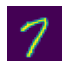

In [15]:
# display a tensor as a image using fastai's show_image function
show_image(seven_tensors[10])

In [16]:
# compute the average over all the images of the intensity of that pixel

# combine all the images in the list into a single 3-dimensional tensor (rank-3 tensor)
torch.stack(three_tensors).shape

torch.Size([6131, 28, 28])

shape attribute tells you the length of each axis.

The semantics of a tensor are up to us. As far as PyTorch is concerned, it is just a bunch of numbers in memory.

In [17]:
# rank: length of a tensor's shape
len(torch.stack(three_tensors).shape)

3

**rank** : the number of axes or dimensions in a tensor

**shape** : the size(length) of each axis of a tensor

In [18]:
# usually when images are floats, the pixel values are expected to be between 0 and 1
# therefore, let's make them as float and divide them by 255
stacked_threes = torch.stack(three_tensors).float() / 255
stacked_sevens = torch.stack(seven_tensors).float() / 255

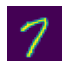

In [19]:
# display a tensor as a image
show_image(seven_tensors[10])

In [20]:
# another way to check a tensor's rank
stacked_threes.ndim

3

torch.stack function's default axis is 0. 

Regarding how it stacks tensors, please refer to the following stackoverflow page.

https://stackoverflow.com/questions/69220221/use-of-torch-stack

In [21]:
# calculate the mean of all the image tensors by taking the mean along dimension 0 of the stacked, rank-3 tensor
mean3 = stacked_threes.mean(0)
mean3.shape

torch.Size([28, 28])

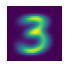

In [22]:
# according to this dataset, this is the ideal number 3
show_image(mean3)

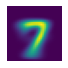

In [23]:
# do the same for 7s
mean7 = stacked_sevens.mean(0)
show_image(mean7)

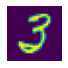

In [24]:
# let's pick an arbitrary 3 and measure its distance from our "ideal digits" (mean3 and mean7)
random3 = stacked_threes[12]
show_image(random3)

**How can we determine its distance from our ideal 3?**

We can't just add up the differences between the pixels of this images and the ideal digit because some differences will be positive, while others will be negative, and these differences will cancel out. 

**Two Main Ways**

*   Mean Absolute Difference (or L1 norm)
*   Root Mean Squared Error (or L2 norm)

In [25]:
# take the mean of  the absolute value of differences
L1_norm = (random3 - mean3).abs().mean()

# tkae the mean of the square of differences
# and then take the square root (which undoes the squaring)
L2_norm = ((random3 - mean3)**2).mean().sqrt()
L1_norm, L2_norm

(tensor(0.1286), tensor(0.2366))

In [26]:
# let's see random3's distance from the ideal 7 tensor
L1_norm_cf = (random3 - mean7).abs().mean()
L2_norm_cf = ((random3 - mean7)**2).mean().sqrt()
L1_norm_cf, L2_norm_cf

(tensor(0.1534), tensor(0.2920))

In both cases, the distance between our 3 and the ideal 3 is less than the distance to the ideal 7, so our simple model will give the right prediction in this case.

**PyTorch's loss functions**
PyTorch already provides both of these as loss functions


```
import torch.nn.functional as F # is available by default under that name in fastai
F.l1_loss(random3.float(), mean7)
F.mse_loss(random3, mean7).sqrt()
```

In [27]:
# we don't have to import Pytorch loss function
# as it is available by default under F in fastai

F.l1_loss(random3.float(), mean7), F.mse_loss(random3, mean7).sqrt()

(tensor(0.1534), tensor(0.2920))

**The Difference between L1 norm and Mean Squared Error (MSE)**

MSE will penalize bigger mistakes more heavily and be more lenient with small mistakes than L1 norm.

**NumPy Arrays VS PyTorch Tensors**

NumPy provides similar functionality and similar API to that provided by Pytorch; 

however, it does **NOT** support using the **GPU** or **calculating gradients**, which are both critical for deep learning.

<br>

| Numpy array | PyTorch tensor
|:----: | :----:  |
|       | GPU     | 
| multidimensional table |  multidimensional table |
|fast computation |  fast computation|
| jagged array  | No jagged array |
| any data type | basic numeric type |


<br>

**What is a jagged array?**
It's called 'jagged array' or 'irregular array' when member arrays have different lengths as the illustration below.

<img src="https://scaler.com/topics/images/what-is-a-jagged-array.webp" width=400></img>
 


In [28]:
# create an array or tensor
# pass a list, or a list of lists, or list of lists of lists to array or tensor
data = [[1,2,3],[4,5,6]]
arr = np.array(data)
tns = tensor(data)

arr # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [29]:
tns # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [30]:
# select a row
tns[1]

tensor([4, 5, 6])

In [31]:
# select a column
tns[:, 1]

tensor([2, 5])

In [32]:
# can use the standard operations such as +, -, *, /
tns + 1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [33]:
# view tensor type
tns.type()

'torch.LongTensor'

In [34]:
# automatically change the type as needed
(tns * 1.5).type()

'torch.FloatTensor'

## 3.   Computing Metrics Using Broadcasting

We're going to calculate a *metric* to tell use how good our model is. 
<br>
<br>
Loss functions such as mean absolute error or mean squared errors are not understandable to most people; in practice, we normally use *accuracy* as the metrics for classification models.
<br>
<br>
Let's calculate our metrics over a validation set.

In [35]:
# create tensors for 3s and 7s from validation set directory
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])

# convert pixel values as float and divide by 255 to make pixel values between 0 and 1 values
valid_3_tens = valid_3_tens.float() / 255
valid_7_tens = valid_7_tens.float() / 255


In [36]:
# view the shape of tensors
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [37]:
# define a function that computes the distance between two images
def mnist_distance(a, b):
  return (a-b).abs().mean((-1,-2)) 
  # mean(-1, -2) tells PyTorch that we want to take the mean
  # ranging over the values indexed 
  # by the last two axes of the tensor.

**Calculate the distance to the ideal 3 for every image in the validation set**
<br>
no need to loop over 1010 images because **PyTorch will use broadcasting** when it tries to perform a simple subtraction operation between two tensors of different ranks. 

<br>

*   validation set (rank-3) :   [1010, 28, 28]
*   mean 3 (rank-2) :   [28, 28]

<br>
PyTorch will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank.


<br>
<br>
<img src = 'https://i.stack.imgur.com/kU0mv.png' width = 400></img>


PyTorch treats mean3, a rank-2 tensor representing a single image, as if it were 1,010 copies of the same image, and then subtracts each of those copies from each validation set. 

<br>

There are a couple of **important points** about how broadcasting is implemented, which makes it valuable not just for expressivity but also for performance:



*   PyTorch doesn't actually copy mean3 1,010 times. It pretends it were a tensor of that shape, but doesn't allocate any additional memory.
*   It does the whole calculation in C (or, if you'e using a GPU, in CUDA, the equivalent of C on the CPU), tens of thousands of times faster than pure Python (up to milions of times faster on a GPU).



In [38]:
# calculate the distance between validation set images of 3 and ideal image of 3
mnist_distance(valid_3_tens, mean3)

tensor([0.1263, 0.1044, 0.1207,  ..., 0.1440, 0.1222, 0.1587])

In [39]:
# create a function, is_3
def is_3(x):
  # logic: if the distance between the digit in question and the ideal 3 
  # is less than the distance to the ideal 7, then it's 3.
  return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [40]:
# let's test it. 
is_3(random3), is_3(random3).float()

(tensor(True), tensor(1.))

In [41]:
# thanks to broadcasting, we can test it on the full validation set of 3s
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [42]:
is_3(valid_7_tens)

tensor([False, False, False,  ..., False, False, False])

In [43]:
# calculate the accuracy
# by taking the average of that function for all 3s and its inverse for all 7s
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = 1 - is_3(valid_7_tens).float().mean()

accuracy_3s, accuracy_7s

(tensor(0.9168), tensor(0.9854))

We're getting over 90% accuracy on both 3s and 7s.

We're classifying only 2 out of the 10 possible digits so far. To do better, let's learn about one that can automatically modify itself to improve its performance, that is, **the training process and SGD**

## 4.   Stochastic Gradient Descent

[Arthur Samuel](https://en.wikipedia.org/wiki/Arthur_Samuel_(computer_scientist) described machine learning as below.

> Suppose we arrange for some automatic means of testing the effectiveness of any current weight assignment in terms of actual performance and provide a mechanism for altering the weight assignment so as to maximize the performance. We need not to go into the details of such a performance to see that it could be made entirely automatic and to see that a machine so programmed would "learn" from its experience.

<br>

**have a model that can get better and better - that can learn.**

The problem with pixel similarity approach we practised earlier is that we can't improve it by modifying a set of parameters or weight. 

<br>

**have a weight assignments or any way of improving based on testing the effectiveness of a weight assignment**

We could look at each individual pixel and come up with a set of weights for each such that the highest weights are associated with those pixels are most likely to be black for a particular category.

> the weight for pixel where the color is white < the weight for pixel where the color is black



```
# the probability of being the number 3
def pr_three(x, w): return (x*w).sum()
```

We want to find the specific values for the vector *w* that causes the result of our fuction to be high for those images that are 3s and low for those images that are not.

**search for the best vector w** by updating the weights to make them better

<br>

**7 steps to turn this function into a machine learning classifier**

1. Initialize the weights
2. Use these weights to predict
3. Calculate its loss
4. Caculate the gradient
> Gradient measures for each weights how changing that weight would change the loss.
5. Step (that is, change) all the weights based on the calculation
6. Go back to step 2 and repeat the process
7. Iterate untill you decide to stop the training process


In [47]:
def f(x): return x**2

In [60]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max, 100)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

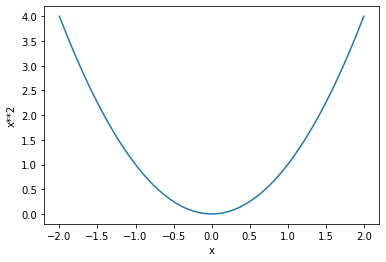

In [61]:
plot_function(f, tx= 'x', ty ='x**2')

In [62]:
xt = tensor(3.).requires_grad_()

In [63]:
# calculate function
# and it has a gradient function it will be using to calculate when needed
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [64]:
# backward refers to 'backpropagation'
# backpropagation : the process of calculating the derivative of each layer
yt.backward()

In [65]:
# check the grad attribute of our tensor
xt.grad

tensor(6.)

High school calculus rule : **the derivative of x**2 is 2*x.**

In [69]:
# repeat the preceeding steps with a vector argument
xt2 = tensor([3. ,4. ,10.]).requires_grad_()
xt2

tensor([ 3.,  4., 10.], requires_grad=True)

In [72]:
# add sum to our function so it can take a vector and return a scalar
def f(x): return (x**2).sum()

In [73]:
# calculate function
yt2 = f(xt2)
yt2

tensor(125., grad_fn=<SumBackward0>)

In [74]:
# backpropagation: calcuate the derivative 
yt2.backward()

# check the gradient
xt2.grad

tensor([ 6.,  8., 20.])